In [1]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [10]:

#class for plotting
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2),
                        self.metrics[metric],
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2),
                            self.metrics['val_' + metric],
                            label='val_' + metric)

            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder):
    metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/processed_data.csv')
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (36, 33):
                      print(f'{filename} does not have the right shape, shape: {image_array.shape}')
                      continue
                    image_array = normalize(image_array)
                    #image_array = tensorflow.image.grayscale_to_rgb(image_array)
                    #print(image_array.shape)
                    image_array = np.ndarray(shape=(image_array.shape[0], image_array.shape[1], 1), dtype= np.uint8)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    #print(f'Double check: image {new_filename} has label {label}')
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        #print(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        #print(image_data_tensor)
        image_data_tensor = tensorflow.image.grayscale_to_rgb(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds


root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted_3/mfcc"
data = conv_array(root_folder)
input_shape = data['fold1'][0].shape
#input_shape = input_shape + (3,)
print(input_shape)

100%|██████████| 837/837 [00:11<00:00, 75.89it/s] 


(873, 36, 33, 3)


In [11]:
print(input_shape)
input_shape2 = input_shape[1:4]
print(input_shape2)

(873, 36, 33, 3)
(36, 33, 3)


  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.79561, saving model to model.h5
59/59 - 16s - loss: 2.1314 - accuracy: 0.3780 - val_loss: 3.7956 - val_accuracy: 0.2027 - lr: 0.0010 - 16s/epoch - 268ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.79561 to 2.20209, saving model to model.h5
59/59 - 3s - loss: 1.5988 - accuracy: 0.4791 - val_loss: 2.2021 - val_accuracy: 0.3242 - lr: 0.0010 - 3s/epoch - 52ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.20209 to 1.82526, saving model to model.h5
59/59 - 2s - loss: 1.4935 - accuracy: 0.5092 - val_loss: 1.8253 - val_accuracy: 0.3780 - lr: 0.0010 - 2s/epoch - 36ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.82526 to 1.52604, saving model to model.h5
59/59 - 2s - loss: 1.3423 - accuracy: 0.5508 - val_loss: 1.5260 - val_accuracy: 0.4055 - lr: 0.0010 - 2s/epoch - 36ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.52604
59/59 - 1s - loss: 1.2682 - accuracy: 0.5682 - val_loss: 1.

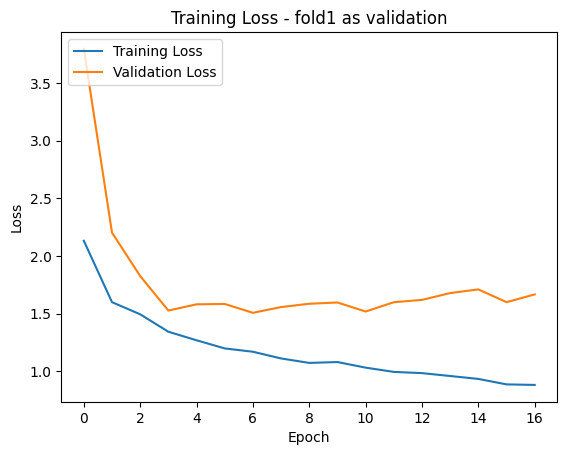

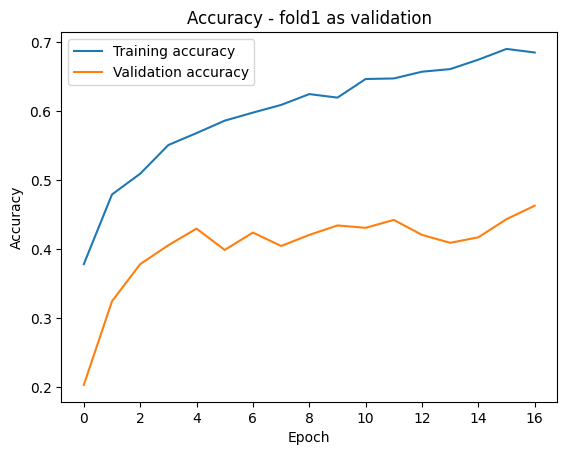

 10%|█         | 1/10 [00:56<08:32, 56.93s/it]

Training using fold2 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.66081, saving model to model.h5
59/59 - 15s - loss: 2.1215 - accuracy: 0.3824 - val_loss: 2.6608 - val_accuracy: 0.2455 - lr: 0.0010 - 15s/epoch - 252ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.66081 to 1.85125, saving model to model.h5
59/59 - 3s - loss: 1.6111 - accuracy: 0.4746 - val_loss: 1.8513 - val_accuracy: 0.3457 - lr: 0.0010 - 3s/epoch - 44ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.85125 to 1.73439, saving model to model.h5
59/59 - 2s - loss: 1.4744 - accuracy: 0.5156 - val_loss: 1.7344 - val_accuracy: 0.3547 - lr: 0.0010 - 2s/epoch - 34ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.73439 to 1.55788, saving model to model.h5
59/59 - 2s - loss: 1.3666 - accuracy: 0.5514 - val_loss: 1.5579 - val_accuracy: 0.4144 - lr: 0.0010 - 2s/epoch - 40ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.55788 to 1.49094, saving model to model.h5
59/59 - 3s - loss: 1.3305 - a

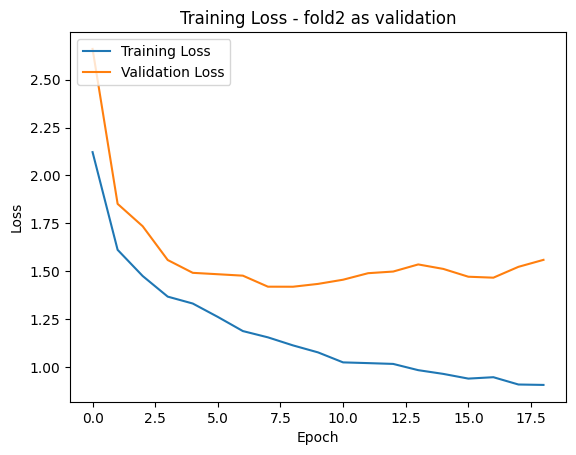

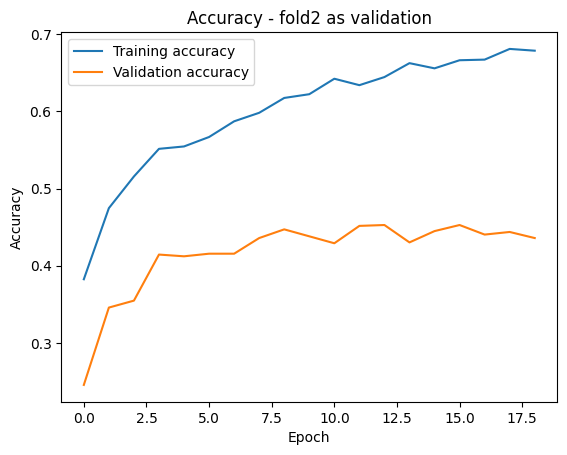

 20%|██        | 2/10 [01:55<07:42, 57.86s/it]

Training using fold3 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.86401, saving model to model.h5
58/58 - 13s - loss: 2.0626 - accuracy: 0.3811 - val_loss: 2.8640 - val_accuracy: 0.2908 - lr: 0.0010 - 13s/epoch - 225ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.86401 to 2.35736, saving model to model.h5
58/58 - 3s - loss: 1.5838 - accuracy: 0.4806 - val_loss: 2.3574 - val_accuracy: 0.3254 - lr: 0.0010 - 3s/epoch - 58ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.35736 to 1.96738, saving model to model.h5
58/58 - 2s - loss: 1.4223 - accuracy: 0.5282 - val_loss: 1.9674 - val_accuracy: 0.3600 - lr: 0.0010 - 2s/epoch - 36ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.96738 to 1.90681, saving model to model.h5
58/58 - 2s - loss: 1.3238 - accuracy: 0.5470 - val_loss: 1.9068 - val_accuracy: 0.3795 - lr: 0.0010 - 2s/epoch - 35ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.90681 to 1.78795, saving model to model.h5
58/58 - 2s - loss: 1.2523 - a

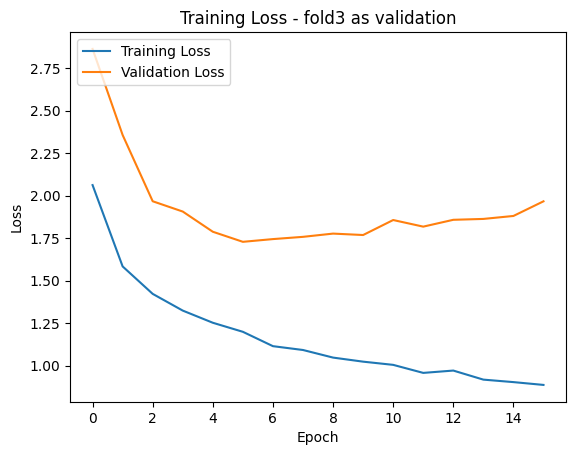

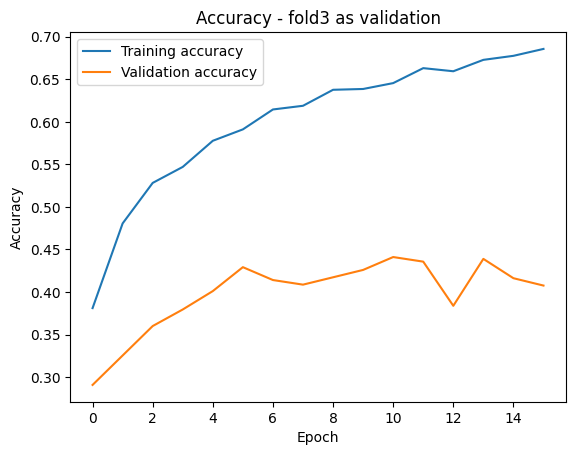

 30%|███       | 3/10 [02:53<06:45, 57.95s/it]

Training using fold4 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.31111, saving model to model.h5
58/58 - 14s - loss: 2.0973 - accuracy: 0.3843 - val_loss: 2.3111 - val_accuracy: 0.3303 - lr: 0.0010 - 14s/epoch - 235ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.31111 to 1.89525, saving model to model.h5
58/58 - 3s - loss: 1.5862 - accuracy: 0.4915 - val_loss: 1.8952 - val_accuracy: 0.3364 - lr: 0.0010 - 3s/epoch - 43ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.89525 to 1.81517, saving model to model.h5
58/58 - 2s - loss: 1.4080 - accuracy: 0.5338 - val_loss: 1.8152 - val_accuracy: 0.3626 - lr: 0.0010 - 2s/epoch - 35ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.81517
58/58 - 1s - loss: 1.3260 - accuracy: 0.5534 - val_loss: 1.8311 - val_accuracy: 0.3636 - lr: 0.0010 - 1s/epoch - 23ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.81517
58/58 - 2s - loss: 1.2652 - accuracy: 0.5704 - val_loss: 1.8439 - val_accuracy: 0.3525 - 

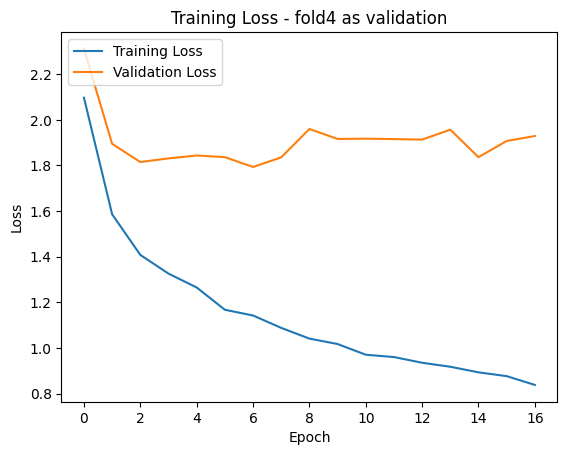

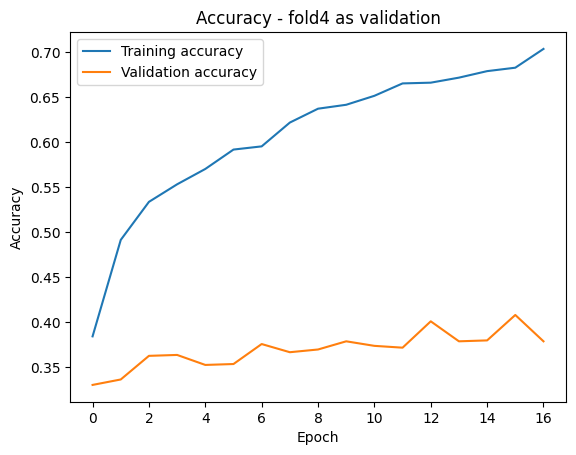

 40%|████      | 4/10 [03:46<05:35, 55.96s/it]

Training using fold5 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.78588, saving model to model.h5
60/60 - 15s - loss: 2.1518 - accuracy: 0.3750 - val_loss: 3.7859 - val_accuracy: 0.2400 - lr: 0.0010 - 15s/epoch - 243ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.78588 to 2.12793, saving model to model.h5
60/60 - 3s - loss: 1.6293 - accuracy: 0.4734 - val_loss: 2.1279 - val_accuracy: 0.3246 - lr: 0.0010 - 3s/epoch - 53ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.12793 to 1.82895, saving model to model.h5
60/60 - 2s - loss: 1.4627 - accuracy: 0.5121 - val_loss: 1.8290 - val_accuracy: 0.4108 - lr: 0.0010 - 2s/epoch - 34ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.82895 to 1.67823, saving model to model.h5
60/60 - 2s - loss: 1.3607 - accuracy: 0.5343 - val_loss: 1.6782 - val_accuracy: 0.4477 - lr: 0.0010 - 2s/epoch - 36ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.67823 to 1.50752, saving model to model.h5
60/60 - 3s - loss: 1.2569 - a

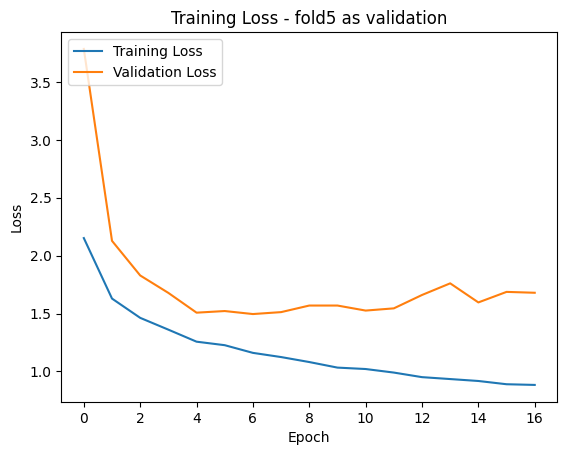

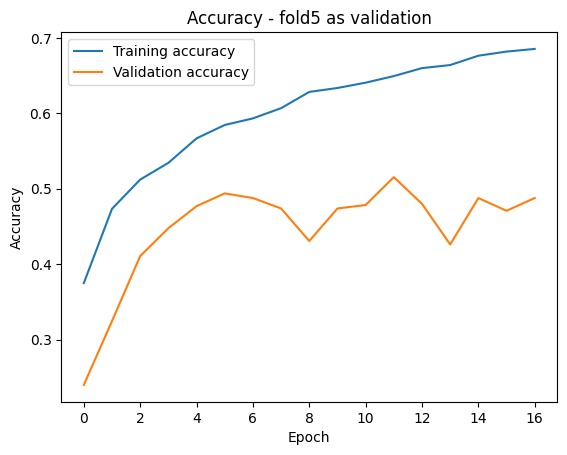

 50%|█████     | 5/10 [04:40<04:36, 55.28s/it]

Training using fold6 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.92492, saving model to model.h5
59/59 - 14s - loss: 2.1037 - accuracy: 0.3833 - val_loss: 2.9249 - val_accuracy: 0.2843 - lr: 0.0010 - 14s/epoch - 231ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.92492 to 2.31918, saving model to model.h5
59/59 - 3s - loss: 1.5879 - accuracy: 0.4862 - val_loss: 2.3192 - val_accuracy: 0.3293 - lr: 0.0010 - 3s/epoch - 49ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.31918 to 1.93527, saving model to model.h5
59/59 - 2s - loss: 1.4208 - accuracy: 0.5373 - val_loss: 1.9353 - val_accuracy: 0.3815 - lr: 0.0010 - 2s/epoch - 41ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.93527 to 1.84025, saving model to model.h5
59/59 - 3s - loss: 1.3103 - accuracy: 0.5570 - val_loss: 1.8403 - val_accuracy: 0.3949 - lr: 0.0010 - 3s/epoch - 43ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.84025 to 1.82235, saving model to model.h5
59/59 - 2s - loss: 1.2171 - a

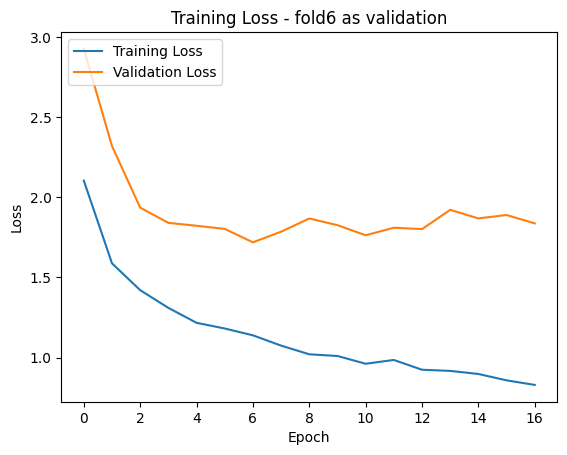

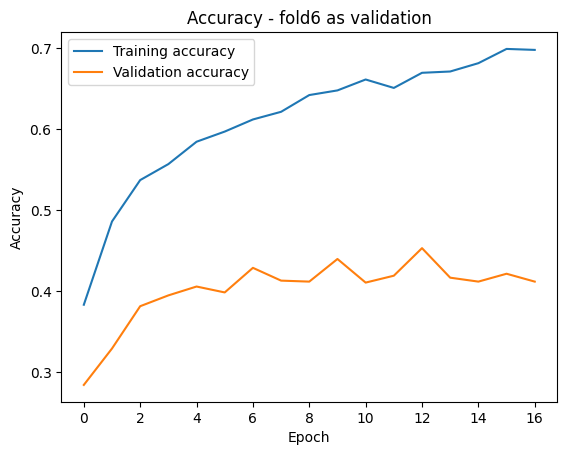

 60%|██████    | 6/10 [05:40<03:48, 57.01s/it]

Training using fold7 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.40347, saving model to model.h5
59/59 - 15s - loss: 2.0970 - accuracy: 0.3802 - val_loss: 2.4035 - val_accuracy: 0.2780 - lr: 0.0010 - 15s/epoch - 259ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.40347 to 2.00618, saving model to model.h5
59/59 - 3s - loss: 1.5965 - accuracy: 0.4858 - val_loss: 2.0062 - val_accuracy: 0.3544 - lr: 0.0010 - 3s/epoch - 49ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.00618 to 1.73328, saving model to model.h5
59/59 - 2s - loss: 1.4343 - accuracy: 0.5243 - val_loss: 1.7333 - val_accuracy: 0.3902 - lr: 0.0010 - 2s/epoch - 42ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 1.73328
59/59 - 2s - loss: 1.2968 - accuracy: 0.5619 - val_loss: 1.7649 - val_accuracy: 0.3628 - lr: 0.0010 - 2s/epoch - 30ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.73328 to 1.62969, saving model to model.h5
59/59 - 3s - loss: 1.2616 - accuracy: 0.5634 - val_loss: 1.

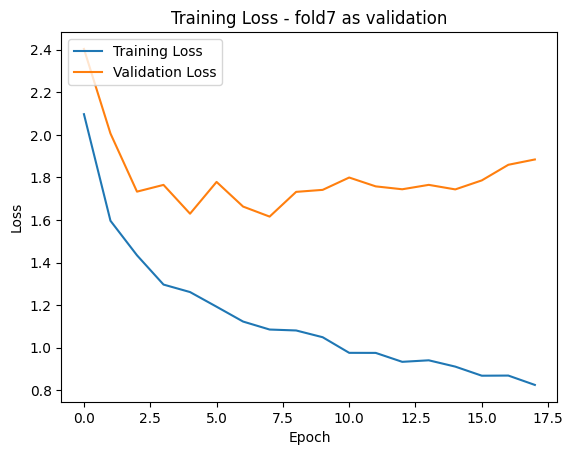

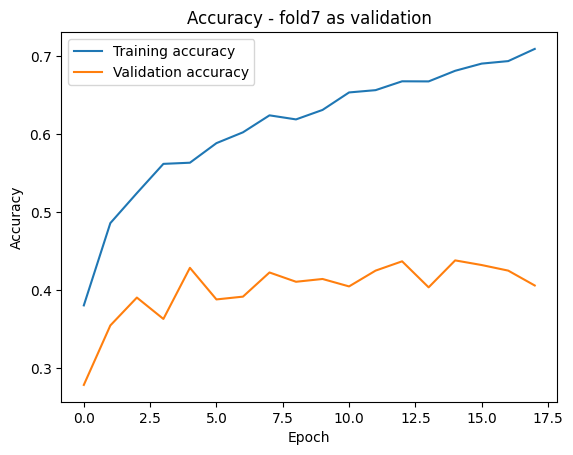

 70%|███████   | 7/10 [06:39<02:52, 57.51s/it]

Training using fold8 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 3.51451, saving model to model.h5
59/59 - 13s - loss: 2.1608 - accuracy: 0.3643 - val_loss: 3.5145 - val_accuracy: 0.2854 - lr: 0.0010 - 13s/epoch - 226ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.51451 to 2.56668, saving model to model.h5
59/59 - 3s - loss: 1.6223 - accuracy: 0.4791 - val_loss: 2.5667 - val_accuracy: 0.4380 - lr: 0.0010 - 3s/epoch - 50ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.56668 to 2.02946, saving model to model.h5
59/59 - 2s - loss: 1.4415 - accuracy: 0.5130 - val_loss: 2.0295 - val_accuracy: 0.4938 - lr: 0.0010 - 2s/epoch - 34ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.02946 to 1.84403, saving model to model.h5
59/59 - 2s - loss: 1.3248 - accuracy: 0.5532 - val_loss: 1.8440 - val_accuracy: 0.5099 - lr: 0.0010 - 2s/epoch - 34ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 1.84403
59/59 - 1s - loss: 1.2579 - accuracy: 0.5622 - val_loss: 2.

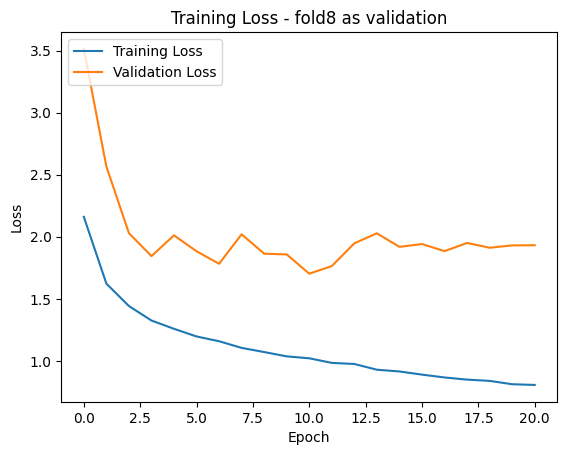

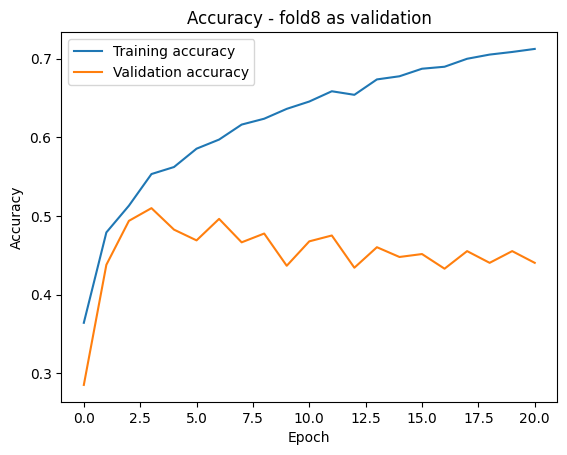

 80%|████████  | 8/10 [07:37<01:55, 57.73s/it]

Training using fold9 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.74100, saving model to model.h5
59/59 - 13s - loss: 2.1288 - accuracy: 0.3775 - val_loss: 2.7410 - val_accuracy: 0.3076 - lr: 0.0010 - 13s/epoch - 213ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.74100 to 1.87455, saving model to model.h5
59/59 - 4s - loss: 1.5743 - accuracy: 0.4781 - val_loss: 1.8745 - val_accuracy: 0.3995 - lr: 0.0010 - 4s/epoch - 59ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.87455 to 1.67063, saving model to model.h5
59/59 - 3s - loss: 1.4131 - accuracy: 0.5324 - val_loss: 1.6706 - val_accuracy: 0.4522 - lr: 0.0010 - 3s/epoch - 46ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.67063 to 1.57028, saving model to model.h5
59/59 - 2s - loss: 1.3476 - accuracy: 0.5491 - val_loss: 1.5703 - val_accuracy: 0.4767 - lr: 0.0010 - 2s/epoch - 35ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.57028 to 1.53885, saving model to model.h5
59/59 - 2s - loss: 1.2540 - a

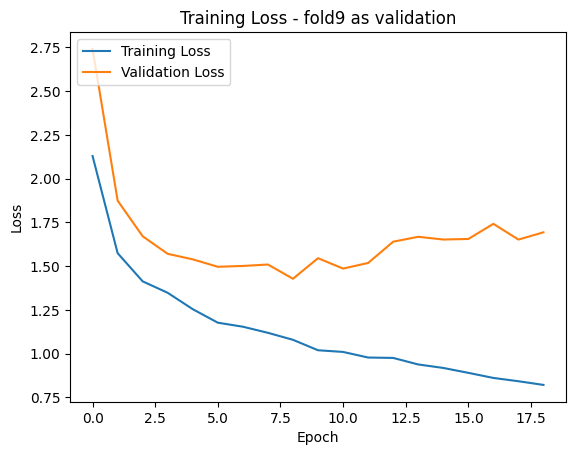

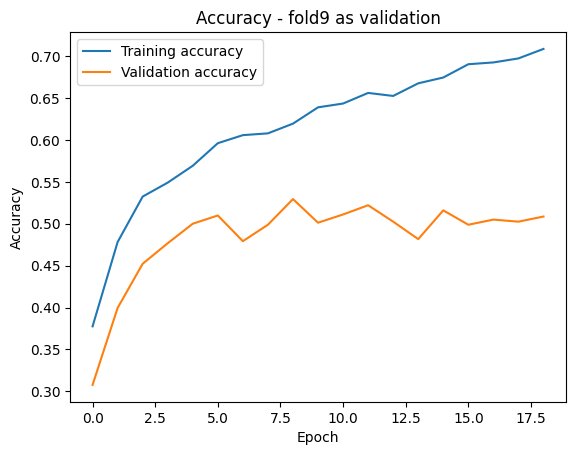

 90%|█████████ | 9/10 [08:35<00:57, 57.70s/it]

Training using fold10 as validation
Epoch 1/30

Epoch 1: val_loss improved from inf to 2.68045, saving model to model.h5
59/59 - 14s - loss: 2.1613 - accuracy: 0.3678 - val_loss: 2.6804 - val_accuracy: 0.2545 - lr: 0.0010 - 14s/epoch - 235ms/step
Epoch 2/30

Epoch 2: val_loss improved from 2.68045 to 1.73040, saving model to model.h5
59/59 - 3s - loss: 1.6113 - accuracy: 0.4743 - val_loss: 1.7304 - val_accuracy: 0.3978 - lr: 0.0010 - 3s/epoch - 49ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.73040 to 1.72437, saving model to model.h5
59/59 - 2s - loss: 1.4409 - accuracy: 0.5138 - val_loss: 1.7244 - val_accuracy: 0.4062 - lr: 0.0010 - 2s/epoch - 35ms/step
Epoch 4/30

Epoch 4: val_loss improved from 1.72437 to 1.71485, saving model to model.h5
59/59 - 3s - loss: 1.3158 - accuracy: 0.5513 - val_loss: 1.7148 - val_accuracy: 0.4158 - lr: 0.0010 - 3s/epoch - 45ms/step
Epoch 5/30

Epoch 5: val_loss improved from 1.71485 to 1.69188, saving model to model.h5
59/59 - 3s - loss: 1.2716 - 

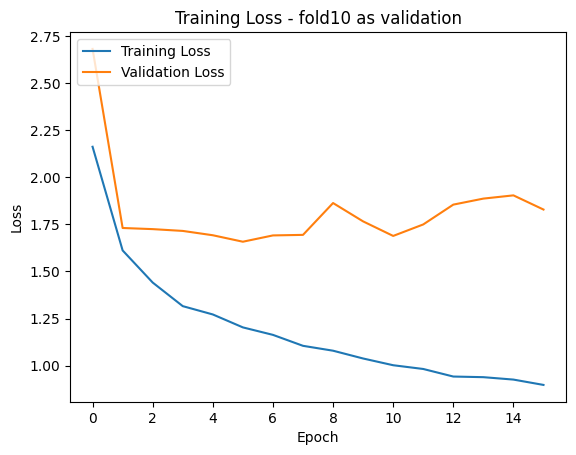

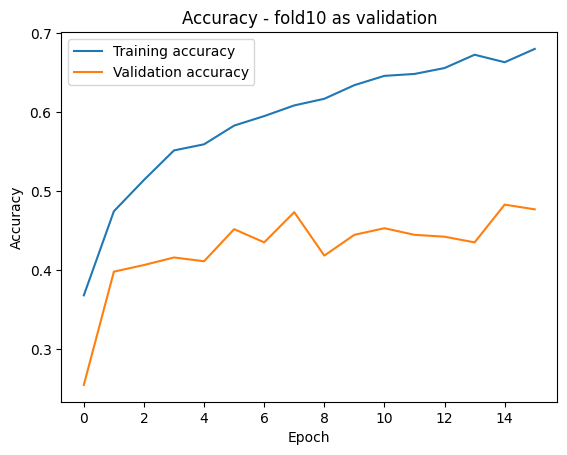

100%|██████████| 10/10 [09:34<00:00, 57.43s/it]


List of scores[0.46277204155921936, 0.43581080436706543, 0.40756756067276, 0.3787878751754761, 0.48769229650497437, 0.4119076430797577, 0.40572792291641235, 0.4404466450214386, 0.5085784196853638, 0.4767025113105774]
Average accuracy: 0.4415993720293045
Trained only the last -8 layers
27/27 [==============================] - 3s 21ms/step
Total-test-data; 837 	accurately-predicted-data: 399 	 wrongly-predicted-data:  438
Accuracy: 47.67 %


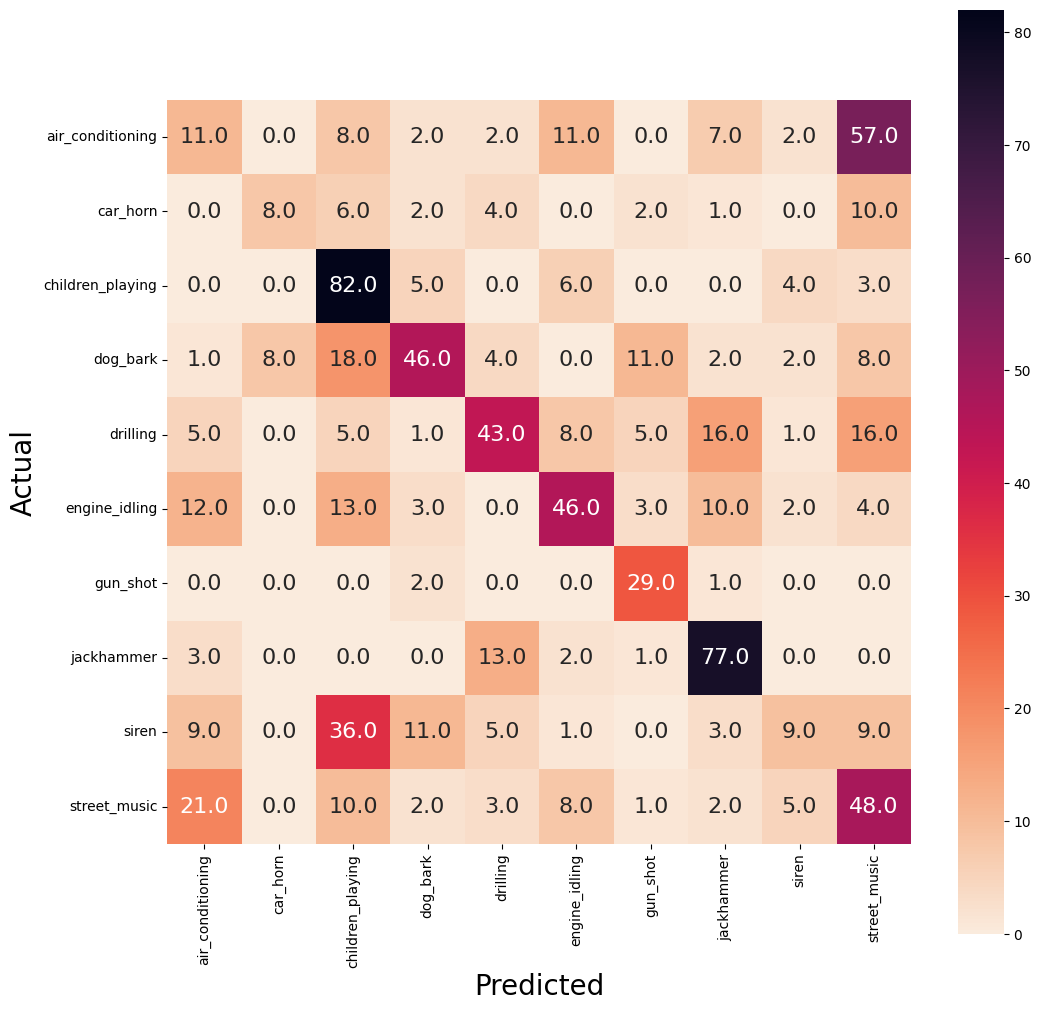

In [12]:
tensorflow.keras.backend.clear_session()

metric = 'accuracy' #evaluation metric
#metric = tensorflow.keras.metrics.MeanAveragePrecisionMetric(topn=2)
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 30
batch_size = 128
early_stop = 10 # early stoppping after 3 epochs with no improvement of test data
#trainable layers needs a minus infront
trainable_layers = -8
dropout_rate = 0.5
learning_rate = 0.001


def model_k_cross(data):
    list_scores = []
    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()

        #Densenet121 model using pretrained weights from imagenet
        model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=input_shape[1:4], classes=10)

        x=model_d.output
        x= GlobalAveragePooling2D()(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        x= Dense(1024,activation='relu')(x)
        x= Dense(512,activation='relu')(x)
        x= BatchNormalization()(x)
        x= Dropout(dropout_rate)(x)
        preds=Dense(10,activation='softmax')(x) #FC-layer
        model=Model(inputs=model_d.input,outputs=preds)

        #instance of Adam optimizer
        Adam = keras.optimizers.Adam(learning_rate=learning_rate)


        #To avoid the problem of overfitting, avoid training the entire network. layer.trainable=False will freeze all the layers, keeping only the last eight layers (FC) to detect edges and blobs in the image. Once the model is fitted well, it can be fine-tuned by using layer.trainable=True.
        for layer in model.layers[:trainable_layers]:
            layer.trainable=False
        for layer in model.layers[trainable_layers:]:
            layer.trainable=True


        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []

        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)


        #If the model sees no change in validation loss the ReduceLROnPlateau function will reduce the learning rate, which often benefits the model.
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)


        history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                       steps_per_epoch=X_train.shape[0] //128,
                       epochs=num_epoch,
                       verbose=2,
                       callbacks=[anne, checkpoint, EarlyStoppingCallback],
                       validation_data=(X_val, y_val))

        # Evaluation
        scores = model.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])


        # Plot training history - loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()


    average_acc = sum(list_scores) / len(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc}')
    print(f'Trained only the last {trainable_layers} layers')

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

    Ypred = model.predict(X_val)

    for i in range(len(Ypred)):
        if np.argmax(Ypred[i]) == np.argmax(y_val[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1

    Ypred = np.argmax(Ypred, axis=1)
    Ytrue = np.argmax(y_val, axis=1)
    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)


    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')


model_k_cross(data)

